## Libraries

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import random

In [3]:
CLEAR_CLASS = 0
FIELD_CLASS = 1
MASK_CLASS = 2
PROBE_CLASS = 3
SCRATCH_CLASS = 4

## Helper functions
Here we declare some functions that will help us later with loading the data.

In [4]:
# function to quickly convert from classification outputs to strings
def defect_class_to_str(defect_type):
    type_str = ""
    if defect_type == CLEAR_CLASS:
        type_str = 'clear'
    if defect_type == FIELD_CLASS:
        type_str = 'field'
    if defect_type == MASK_CLASS:
        type_str = 'mask'
    if defect_type == PROBE_CLASS:
        type_str = 'probe'
    if defect_type == SCRATCH_CLASS:
        type_str = 'scratch'
    if type_str == "":
        raise ValueError(defect_type)
    else:
        return type_str
    
# function that loads single map from the folder of one class
def load_map(index, defect_type):
    type_str = defect_class_to_str(defect_type)
    df = pd.read_csv('data/'+ type_str + '/' + str(index) + '_' + type_str + '.csv')
    wafer_map = df.iloc[:,1:].to_numpy() # data have unnecessary column names which are not relevant
    return wafer_map

def visualize_map(wafer_map):
    plt.figure(figsize=(5,5))
    plt.imshow(wafer_map, cmap='jet', aspect=0.60747) # this aspect value = 65/107 - so it stretches the map to square
    plt.show()
    
    
# loads all of the data
def load_maps():
    n_maps = []
    
    for class_type in range(5):
        n_samples = len(os.listdir('./data/' + defect_class_to_str(class_type)))
        n_maps.append(n_samples)
    
    maps = np.zeros((sum(n_maps), 107, 65))
    y = np.zeros(sum(n_maps))
    
    class_type_i = 0
    
    # basically goes through every folder and loads every CSV file there is in that folder
    for n in n_maps:
        for file_i in range(1,n+1):
            i = file_i-1 + sum(n_maps[0:class_type_i])
            maps[i] = load_map(file_i, class_type_i) 
            y[i] = class_type_i
        class_type_i += 1
    
    return (maps, y)
            
                 

## Data exploration

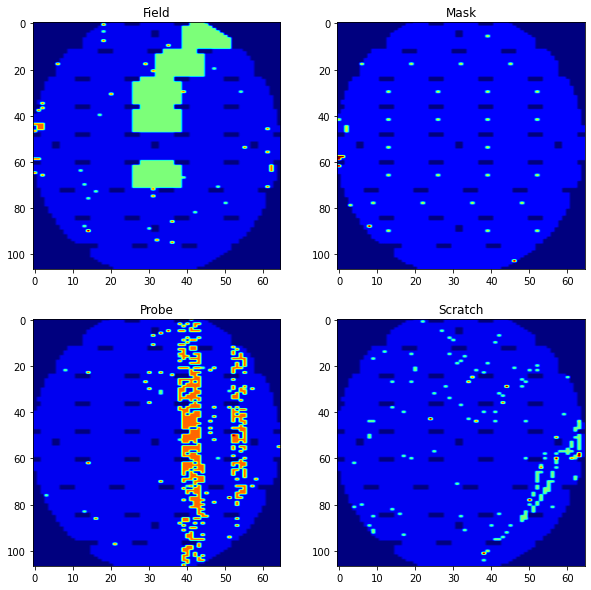

In [5]:
# plotting each class to see how it looks

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0,0].imshow(load_map(9,FIELD_CLASS), cmap='jet', aspect=0.60747)
axes[0,0].set_title('Field')
axes[0,1].imshow(load_map(7, MASK_CLASS), cmap='jet', aspect=0.60747)
axes[0,1].set_title('Mask')
axes[1,0].imshow(load_map(11, PROBE_CLASS), cmap='jet', aspect=0.60747)
axes[1,0].set_title('Probe')
axes[1,1].imshow(load_map(7, SCRATCH_CLASS), cmap='jet', aspect=0.60747)
axes[1,1].set_title('Scratch')
plt.show()

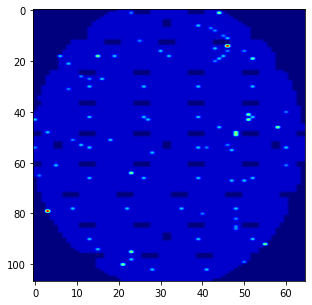

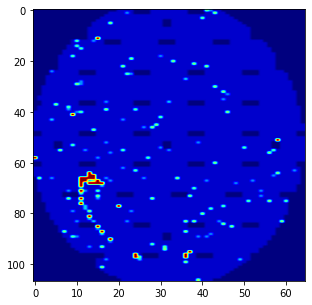

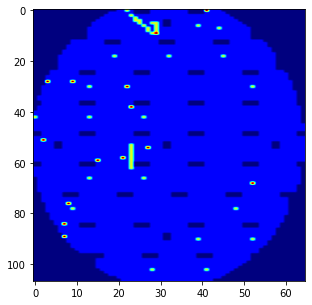

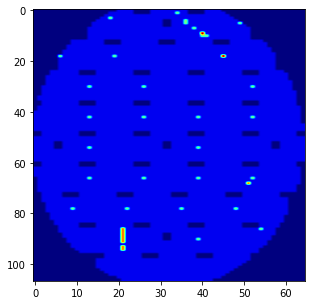

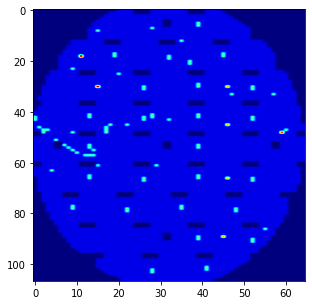

In [6]:
# exploration of the scratch class

for x in range(90,95):
    wafer_map = load_map(x, SCRATCH_CLASS)
    visualize_map(wafer_map)

### Loading the data

In [7]:
# loading the dataset
(x_all, y_all) = load_maps()

Here I calculated how many multilabeled maps there is.

In [44]:
arrs, idxs, counts = np.unique(x_all,axis=0, return_counts=True, return_index=True)

y_multi = []
for i in range(len(y_all)):
    y_multi.append(set())
    y_multi[i].add(y_all[i])

for i in idxs[counts != 1]:
    for x in range(x_all.shape[0]):
        if (x_all[i] == x_all[x]).all(): # both maps equal
           y_multi[i].add(y_all[x]) # therefore add that label to the label set

total = 0
for y in y_multi:
    if len(y) > 1:
        total += 1
        
print("Multilabeled wafer bin maps:", end=' ')
print(total)

Multilabeled wafer bin maps: 214


In [46]:
# data count for each class
counts = []
names = ['Clear', 'Field', 'Mask', 'Probe', 'Scratch']
for defect_type in range(5):
    count = len(os.listdir('./data/' + defect_class_to_str(defect_type)))
    counts.append(count)

plt.figure()
plt.bar(names,counts)
plt.show()

print('Samples without defect:' + str(counts[0]))
print('Samples with defect:' + str(sum(counts[1:])))

Samples without defect:10000
Samples with defect:4474


## 1. CNN - Defect detection

### 1.1 Data transformation and class balancing

In [49]:
# converting labels into binary, 0 = clear, 1 = defect
y_binary = (y_all != 0).astype(np.uint8)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_binary, test_size=.35, random_state=7)

In [50]:
# class balancing
under_sampler = RandomUnderSampler(random_state=10)

n, x, y = x_train.shape
x_train_d2 = x_train.reshape((n,x*y))
x_resampled, y_resampled = under_sampler.fit_resample(x_train_d2, y_train)
x_resampled = x_resampled.reshape((x_resampled.shape[0],x,y))

### 1.2 Model training

In [51]:
model_binary = models.Sequential()

model_binary.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(107, 65, 1)))
model_binary.add(layers.MaxPooling2D())
model_binary.add(layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1)))
model_binary.add(layers.MaxPooling2D((2, 2)))
model_binary.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_binary.add(layers.MaxPooling2D((2, 2)))
model_binary.add(layers.Flatten())
model_binary.add(layers.Dense(256, activation='sigmoid'))
model_binary.add(layers.Dropout(0.3))
model_binary.add(layers.Dense(1, activation='sigmoid'))

model_binary.summary()

model_binary.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_binary.fit(x_resampled, y_resampled,
                    epochs=15,
                    validation_data=(x_test, y_test),
                    batch_size=500)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 105, 63, 32)       320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 52, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 29, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 23, 12, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 11, 6, 128)      

### 1.3 Model evaluation

In [53]:
predictions = np.round(model_binary.predict(x_test))
precision, recall, fscore, support = precision_recall_fscore_support(predictions,y_test)
print("Clear class metrics:")
print("Precision = ", precision[0])
print("Recall = ", recall[0])
print("Fscore= ", fscore[0])
print("=========")
print("Defect class metrics:")
print("Precision = ", precision[1])
print("Recall = ", recall[1])
print("Fscore= ", fscore[1])

Clear class metrics:
Precision =  0.9911403258073735
Recall =  0.992274678111588
Fscore=  0.9917071775807835
Defect class metrics:
Precision =  0.982769623484365
Recall =  0.98026734563972
Fscore=  0.9815168897386871


## 2. CNN pattern classification

### 2.1 Data preparation and balancing

In [55]:
x_defects = np.zeros((sum(counts[1:]),107,65)) # counts refer to sample count for each class, so we start from first non-clear sample
y_defects = np.zeros((sum(counts[1:])))
x_defects = x_all[counts[0]:]
y_defects = y_all[counts[0]:] - 1 # so we have classes starting from 0

x_train, x_test, y_train, y_test = train_test_split(x_defects, y_defects, test_size=.35, random_state=14)

In [993]:
arr, cnts = np.unique(y_train, return_counts=True)

plt.figure()
plt.bar(["field","mask","probe","scratch"],cnts)
plt.show()
print(cnts)

[ 241 1889  700   78]


Class balancing in that case was a bit more complicated, as I mentioned in the report I upscaled the scratch class samples by rotating and fliping existing simples.

Rest of the classes were downsampled to the count of the newly upssampled scratch samples.

In [56]:
x_scratch = x_train[y_train==3.0]
x_scratch_rotated = [np.rot90(np.rot90(wm)) for wm in x_scratch]
x_scratch_flipped = [np.fliplr(wm) for wm in x_scratch]
x_scratch_upsampled = np.concatenate((x_scratch, x_scratch_rotated, x_scratch_flipped)) # upsampled scratch samples

cnt = x_scratch_upsampled.shape[0]

x_train = np.concatenate((x_train[y_train != 3.0], x_scratch_upsampled)) # concat all non scratch samples with new upsampled samples
y_train = np.concatenate((y_train[y_train != 3.0], [3.0] * cnt))

under_sampler = RandomUnderSampler(sampling_strategy={0.0:cnt, 1.0:cnt, 2.0:cnt}, random_state=10) # downsample rest

n, x, y = x_train.shape
x_train_d2 = x_train.reshape((n,x*y))
x_resampled, y_resampled = under_sampler.fit_resample(x_train_d2, y_train)
x_resampled = x_resampled.reshape((x_resampled.shape[0],x,y))

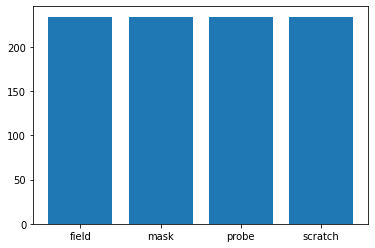

In [57]:
arr, cnts = np.unique(y_resampled, return_counts=True)

plt.figure()
plt.bar(["field","mask","probe","scratch"],cnts)
plt.show()

### 2.2 Model training

In [21]:
model_defects = models.Sequential()

model_defects.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(107, 65, 1)))
model_defects.add(layers.MaxPooling2D())
model_defects.add(layers.Conv2D(64, (6, 6), activation='relu'))
model_defects.add(layers.MaxPooling2D((2, 2)))
model_defects.add(layers.Conv2D(128, (6, 6), activation='relu'))
model_defects.add(layers.MaxPooling2D((2, 2)))
model_defects.add(layers.Flatten())
model_defects.add(layers.Dense(256, activation='relu'))
model_defects.add(layers.Dropout(0.5))
model_defects.add(layers.Dense(4, activation='softmax'))

model_defects.summary()

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min', restore_best_weights=True)

model_defects.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_defects.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_test, y_test),
                    batch_size=250,
                    callbacks=[earlyStopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 105, 63, 32)       320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 52, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 26, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 8, 128)        295040    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 9, 4, 128)       

### 2.3 Model evaluation

In [22]:
predictions = np.argmax(model_defects.predict(x_test), axis=1)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       127
         1.0       0.94      0.95      0.95      1008
         2.0       0.83      0.82      0.82       380
         3.0       0.51      0.45      0.48        51

    accuracy                           0.90      1566
   macro avg       0.81      0.80      0.80      1566
weighted avg       0.90      0.90      0.90      1566



In [60]:
# random test of our model
def random_map_test():
    rnd_example = random.randint(0,x_defects.shape[0])
    defect_type = y_defects[rnd_example]
    wm = x_defects[rnd_example]
    class_probs = model_defects.predict(np.expand_dims(wm,axis=0))
    predicted_class = np.argmax(class_probs)

    visualize_map(wm)
    print("Predicted class: " + defect_class_to_str(predicted_class + 1))
    print("Actual class: " + defect_class_to_str(defect_type + 1))
    print("Class probabilites for [field, mask, probe, scratch]: ", end='')
    print(["{:.2f}".format(float(x)) for x in class_probs[0]])
    
random_map_test()

Predicted class: mask
Actual class: mask
Class probabilites for [field, mask, probe, scratch]: ['0.00', '1.00', '0.00', '0.00']
